# Example of using Cantera with Bamboo

Cantera (https://cantera.org/) is a Python module that is useful for calculating gas properties and combustion temperature. It can be installed easily with Anaconda using `conda install cantera`.

We'll simulate an engine running at the following operating conditions:

- Fuel: Methane (cryogenic)
- Oxidiser: Oxygen
- O/F ratio: 3.5 by mass 
- Chamber pressure: 70 bar 
- Thrust: 20 kN

Cantera will be used to extract the combustion temperature and the throat properties.

Notes:
- We chose the methane coolant pressure to be 100 bar at inlet. This is above its critical pressure of 45.95 bar, and so the methane does not form bubbles in the cooling channels (and won't be susceptible to effects like nucleate boiling). Bamboo does not thoroughly consider two-phase effects in cooling channels, and so if we reduced the coolant inlet pressure so that the methane started boiling then the accuracy of the Bamboo model would be reduced.

In [1]:
# Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials
import bamboo.plot

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import cantera as ct                         # For combustion gas properties
from CoolProp.CoolProp import PropsSI        # For coolant properties

### Equilibrium calculations

Use Cantera to find the cobmustion temperature, and the gas properties at the throat. We ideally want to use the throat properties for bamboo (as opposed to the combustion chamber properties).

In [2]:
# Chamber conditions
pc = 70e5                   # Chamber pressure (Pa)
thrust = 20e3                # Desired thrust (N)
p_amb = 0.2e5               # Ambient pressure (Pa) - let's say here the engine is designed for below sea level pressure
OF = 3.5                    # Oxidiser/fuel mass ratio

# Combustion using Cantera's GRI3.0
gas = ct.Solution('gri30.yaml')
gas.TPY = 300, pc, "CH4:1, O2:3.5"   # Very approximate fuel/ox inlet temperature
gas.equilibrate("HP")
Tc = gas.T                           # Combustion chamber temperature (K)
s0 = gas.s                           # Entropy - needed for isentropic expansion through nozzle
h0 = gas.h                           # Stagnation enthalpy 
gamma_c = gas.cp/gas.cv

# Initial guess of throat static pressure (using chamber properties) - use perfect gas compressible flow relations
pt_initial_guess = pc * (1 + (gamma_c - 1) / 2) ** (-gamma_c / (gamma_c - 1))  

# Iterate to get imperfect gas throat conditions - assume frozen flow (i.e. do not use gas.equilibrate again)
def throat_error(pt):
    gas.SP = s0, pt      
    gamma = gas.cp/gas.cv
    R = gas.cp * (1 - 1/gamma)
    V = np.sqrt(2 * (h0 - gas.h) )                # Definition of stagnation enthalpy
    error = V - np.sqrt(gamma * R * gas.T)        # Difference between actual and sonic velocity - must be zero at throat
    return error

# Use scipy's solver to get throat conditions - you should use these with bamboo
pt = scipy.optimize.fsolve(throat_error, x0 = pt_initial_guess)
pt = float(pt)
cp_t = gas.cp
gamma_t = gas.cp/gas.cv

# Expand to exit conditions to calculate specific impulse
gas.SP = s0, p_amb
isp = np.sqrt(2 * (h0 - gas.h) )   # Definition of stagnation enthalpy

mdot = thrust / isp                # (Thrust) = (Isp) * (total mass flow rate)
mdot_f = mdot/(OF + 1)
mdot_ox = mdot_f * OF

print(f"""
Chamber temperature = {Tc:.2f} K
cp (throat) = {cp_t:.2f} J/kg/K
gamma (throat) = {gamma_t:.3f}

Isp = {isp/9.80665:.2f} s
mdot = {mdot:.3f} kg/s
mdot_f = {mdot_f:.3f} kg/s
mdot_ox = {mdot_ox:.3f} kg/s
""")


Chamber temperature = 3632.42 K
cp (throat) = 2285.83 J/kg/K
gamma (throat) = 1.202

Isp = 326.65 s
mdot = 6.243 kg/s
mdot_f = 1.387 kg/s
mdot_ox = 4.856 kg/s



### Bamboo engine set up
We will now use Bamboo to do the cooling system analysis.

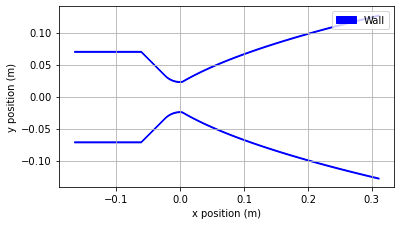


Isp from Bamboo = 328.965 s
Percetange difference from Cantera = 0.7078954400678341 %

Thrust from Bamboo = 20.142 kN



In [3]:
# Set up engine object
perfect_gas = bam.PerfectGas(gamma = gamma_t, cp = cp_t)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

# Chamber geometry
Rc = 0.07                                    # Chamber radius (m)
Dc = 2*Rc                                    # Chamber diameter (m)
Dt = 2*(nozzle.At/np.pi)**0.5                # Throat diameter (m) - get from Bamboo
Ac = np.pi*Rc**2                             # Chamber area (m2)
L_star = 1.2                                 # Guess an L* of 1.2 (L_star = Volume_c / Area_t)
Vc = L_star * nozzle.At                      # Chamber volume from rearranged L*

Lc = ( 24*Vc/np.pi - (Dc**3 - Dt**3)/np.tan(45*np.pi/180) ) / (6*Dc**2)  # Chamber length - equation (1.34) from http://www.braeunig.us/space/propuls.htm 

# Choose an inner wall thickness
inner_wall_thickness = 1.5e-3

# Add geometry
engine.add_geometry(chamber_length = Lc,
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness)

engine.plot_geometry()
plt.show()

# Check how well Bamboo's thrust (perfect gas model) agrees with Cantera
print(f"""
Isp from Bamboo = {engine.isp(p_amb):.3f} s
Percetange difference from Cantera = {100 * (engine.isp(p_amb) - isp/9.80665) / (isp/9.80665)} %

Thrust from Bamboo = {engine.thrust(p_amb)/1e3:.3f} kN
""")

### Cooling channels

Add the cooling channel details. We will use 'vertical' channels (as opposed to spiralling channels). E.g., like the cooling channels in this image: https://slideplayer.com/slide/4179683/14/images/6/Cooling+Channels.jpg

In [4]:
# Coolant jacket
inlet_T = 94                                          # Coolant inlet temperature (K)
inlet_p0 = 100e5                                      # Coolant inlet stagnation pressure (Pa)
inner_wall_material = bam.materials.CopperC106        # Copper inner wall
channel_height = 1.5e-3                               # Radial height of the cooling channels (m)
number_of_ribs = 100                                  # Number of 'ribs' (i.e. number of cooling channels)
blockage_ratio = 0.4                                  # Percentage of the annular flow area that is blocked by ribs

# Transport property functions
def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "METHANE")
    except ValueError:
        return PropsSI("PRANDTL", "Q", 0, "P", p, "METHANE")

def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "METHANE")
    except ValueError:
        return PropsSI("VISCOSITY", "Q", 0, "P", p, "METHANE")

def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "METHANE")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "Q", 0, "P", p, "METHANE")

def rho_coolant(T, p):
    try:
        return PropsSI("DMASS", "T", T, "P", p, "METHANE")
    except ValueError:
        return PropsSI("DMASS", "Q", 0, "P", p, "METHANE")

def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "METHANE")
    except ValueError:
        return PropsSI("CPMASS", "Q", 0, "P", p, "METHANE")

def T_from_h(enthalpy, p):
    return PropsSI("T", "H", enthalpy, "P", p, "METHANE")

def h_from_T(T, p):
    return PropsSI("H", "T", T, "P", p, "METHANE")

# Transport property objects
gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_exhaust,
                                                mu = mu_exhaust,
                                                k = k_exhaust)

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant,
                                                    T_from_enthalpy = T_from_h,
                                                    enthalpy_from_T = h_from_T)


# Add exhaust transport properties
engine.add_exhaust_transport(gas_transport)

# Add cooling jacket
engine.add_cooling_jacket(inner_wall_material, 
                          inlet_T, 
                          inlet_p0, 
                          coolant_transport, 
                          mdot_f, 
                          configuration = "vertical", 
                          channel_height = channel_height,
                          blockage_ratio = blockage_ratio,
                          number_of_ribs = number_of_ribs)

#Run simulation
heating_data = engine.steady_heating_analysis(to_json = False)

print(f"Maximum temperature = {max(heating_data['T_wall_inner']) - 273.15} deg C")

Maximum temperature = 740.0842589958876 deg C


### Plot results

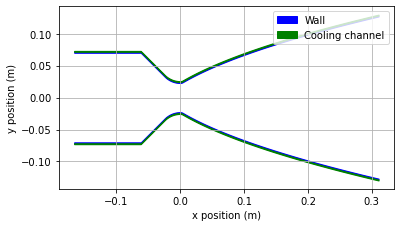

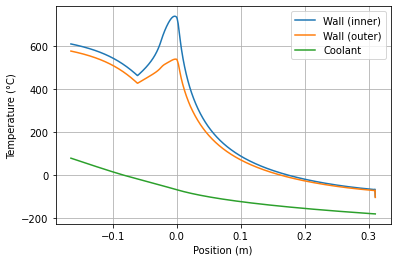

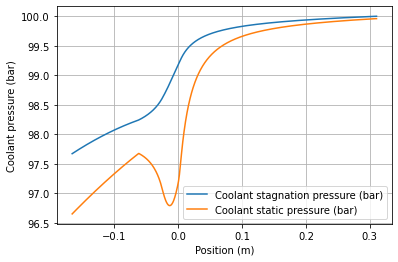

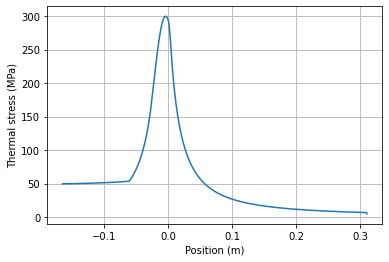

In [5]:
engine.plot_geometry()

bam.plot.plot_temperatures(heating_data)
bam.plot.plot_jacket_pressure(heating_data)
bam.plot.plot_thermal_stress(heating_data)

plt.show()